In [1]:
# Import reqired libraries
import numpy as np
import yfinance as yf
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.dates as mdates
from datetime import datetime
from scipy.stats import norm
import os
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import gaussian_kde
from matplotlib.backends.backend_pdf import PdfPages
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Set display options
pd.set_option('display.max_columns', None)  # Display all columns
pd.set_option('display.width', 1000)        # Set display width to a high value

In [2]:
# Function to print colored text
def print_colored(text, color):
    color_codes = {
        'black': '0;30',
        'red': '0;31',
        'green': '0;32',
        'yellow': '0;33',
        'blue': '0;34',
        'purple': '0;35',
        'cyan': '0;36',
        'white': '0;37',
        'bold_black': '1;30',
        'bold_red': '1;31',
        'bold_green': '1;32',
        'bold_yellow': '1;33',
        'bold_blue': '1;34',
        'bold_purple': '1;35',
        'bold_cyan': '1;36',
        'bold_white': '1;37'
    }
    color_code = color_codes.get(color, '0;30')  # Default to white if color not found
    print(f"\033[{color_code}m{text}\033[0m")

nice_fonts = {
        # Use LaTeX to write all text
        "text.usetex": True,
        "font.family": "serif",
        # Use 10pt font in plots, to match 10pt font in document
        "axes.labelsize": 10,
        "font.size": 10,
        # Make the legend/label fonts a little smaller
        "legend.fontsize": 10,
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
        #'text.latex.preamble' : [r'\usepackage{amsmath}'],
        'mathtext.fontset' : 'stix',
        'mathtext.rm' : 'serif'
}
mpl.rcParams.update(nice_fonts)

In [3]:
# List of assets
#assets = ['AAPL']

# Define the file path
file_path = f'../data/TSLA_enhanced_data.csv'

# Load the data into a DataFrame
df = pd.read_csv(file_path, index_col='Date', parse_dates=True)

In [4]:
df.head(10)

,Open,High,Low,Close,Adj Close,Volume,Daily Return,MA20,MA50,EMA20,EMA50,RSI,MACD,Signal Line,Volatility,Upper Band,Lower Band,Lag_1,Lag_2,Lag_3
Date,,,,,,,,,,,,,,,,,,,,
2010-09-08,1.377333,1.396667,1.373333,1.393333,1.393333,4326000,0.017527,1.301467,1.322240,1.337084,1.361035,67.149673,-0.023951,-0.040687,0.030604,1.435002,1.167932,1.369333,1.403333,1.404000
2010-09-09,1.400000,1.403333,1.379333,1.380667,1.380667,5643000,-0.009090,1.310833,1.318000,1.341234,1.361805,65.047002,-0.020570,-0.036664,0.026861,1.438587,1.183079,1.393333,1.369333,1.403333
2010-09-10,1.383333,1.395333,1.317333,1.344667,1.344667,5799000,-0.026074,1.319400,1.313120,1.341561,1.361133,58.093849,-0.019571,-0.033245,0.027382,1.430183,1.208617,1.380667,1.393333,1.369333
2010-09-13,1.392667,1.393333,1.366667,1.381333,1.381333,5412000,0.027268,1.327400,1.311467,1.345349,1.361925,54.812352,-0.016576,-0.029911,0.026658,1.431257,1.223543,1.344667,1.380667,1.393333
2010-09-14,1.369333,1.440000,1.368667,1.408000,1.408000,9820500,0.019305,1.335200,1.314027,1.351316,1.363732,67.142833,-0.012416,-0.026412,0.026476,1.438645,1.231755,1.381333,1.344667,1.380667
2010-09-15,1.398667,1.466667,1.386000,1.465333,1.465333,10269000,0.040719,1.344633,1.321853,1.362175,1.367716,68.055476,-0.005541,-0.022238,0.027439,1.459394,1.229873,1.408000,1.381333,1.344667
2010-09-16,1.476667,1.544000,1.389333,1.396000,1.396000,40267500,-0.047315,1.351867,1.328707,1.365396,1.368825,58.947347,-0.003429,-0.018476,0.029479,1.459906,1.243827,1.465333,1.408000,1.381333
2010-09-17,1.401333,1.421333,1.320000,1.348667,1.348667,17977500,-0.033906,1.356667,1.332400,1.363803,1.368035,53.625248,-0.004232,-0.015627,0.030789,1.454165,1.259168,1.396000,1.465333,1.408000
2010-09-20,1.378000,1.423333,1.344000,1.404000,1.404000,14212500,0.041028,1.363200,1.337280,1.367631,1.369445,57.465502,-0.001814,-0.012865,0.031780,1.454502,1.271898,1.348667,1.396000,1.465333


In [5]:
features = ['Volume', 'Daily Return', 'MA50', 'RSI', 'MACD', 'Signal Line', 'Volatility']
target = 'Close'

In [6]:
df = df[['Close']]

In [7]:
df.head(10)

,Close
Date,
2010-09-08,1.393333
2010-09-09,1.380667
2010-09-10,1.344667
2010-09-13,1.381333
2010-09-14,1.408000
2010-09-15,1.465333
2010-09-16,1.396000
2010-09-17,1.348667
2010-09-20,1.404000


In [8]:
# Decompose the time series for trend analysis
decomposition = seasonal_decompose(df['Close'], model='additive', period=365)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

In [59]:
# Function to perform EDA for a given asset
def perform_eda(df):
    print_colored(f"--- Analysis for TSLA ---", "blue")
    
    # Decompose the time series for trend analysis
    decomposition = seasonal_decompose(df['Close'], model='additive', period=365)
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    # Create a large plot with subplots for various analyses
    fig, axes = plt.subplots(4, 1, figsize=(14, 12), sharex=False)
    #fig.suptitle(f'Analysis for {asset}', fontsize=16)
    
    # Time series of closing price
    axes[0].plot(df.index, df['Close'], label='Close Price')
    axes[0].set_ylabel('Price')
    axes[0].set_xlabel('Year')
    axes[0].legend(loc='best')
    axes[0].set_xlim(df.index.min(), df.index.max())
    axes[0].set_ylim(df['Close'].min(), df['Close'].max())
    
    # Trend analysis
    axes[1].plot(df.index, trend, label='Trend')
    axes[1].set_xlabel('Year')
    axes[1].set_ylabel('Price')
    axes[1].legend(loc='best')
    axes[1].set_xlim(df.index.min(), df.index.max())
    axes[1].set_ylim(trend.min(), trend.max())
    
    # Trend analysis seasonal
    axes[2].plot(df.index, seasonal, label='Seasonal')
    axes[2].set_xlabel('Year')
    axes[2].set_ylabel('Price')
    axes[2].legend(loc='best')
    axes[2].set_xlim(df.index.min(), df.index.max())
    axes[2].set_ylim(seasonal.min(), seasonal.max())
    
    # Trend analysis residual
    axes[3].plot(df.index, residual, label='Residual')
    axes[3].set_xlabel('Year')
    axes[3].set_ylabel('Price')
    axes[3].legend(loc='best')
    axes[3].set_xlim(df.index.min(), df.index.max())
    axes[3].set_ylim(residual.min(), residual.max())
    
    fig.subplots_adjust(left=0.04,
                bottom=0.02, 
                right=0.98, 
                top=0.99, 
                wspace=0.2, 
                hspace=0.3)

    # Save the figure to the PDF and show it
    plt.show()

--- Analysis for TSLA ---


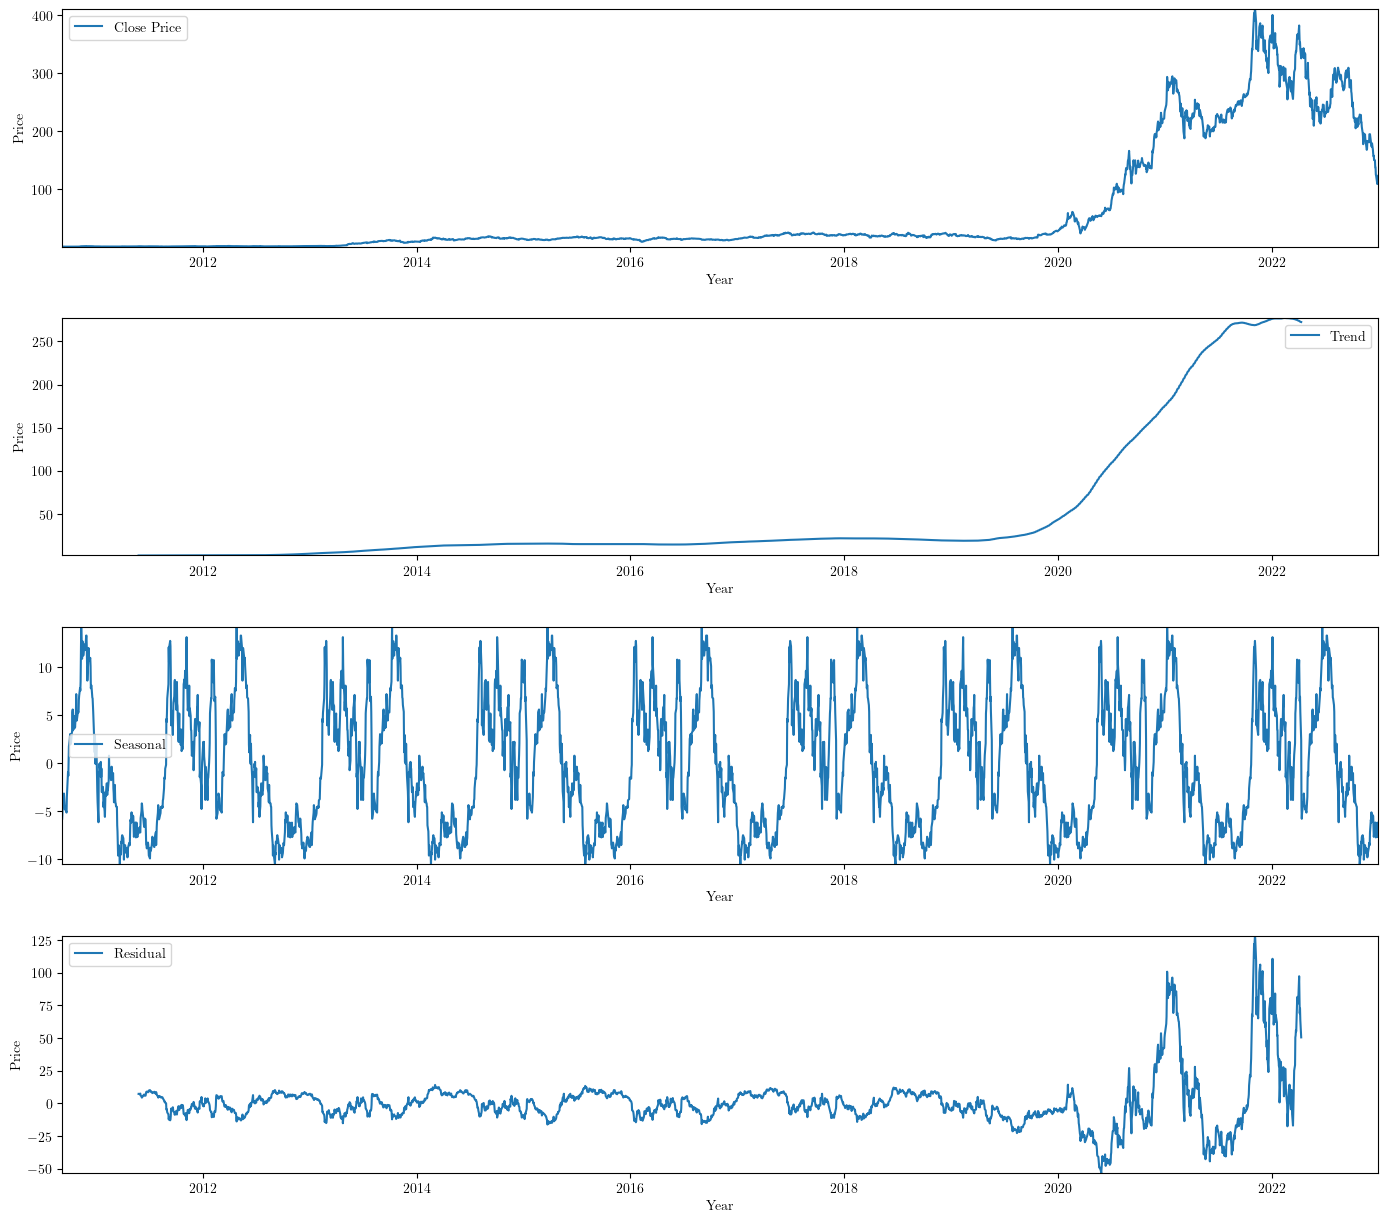

In [60]:
perform_eda(df)

In [25]:
# PERFORM LINEAR FITTING TO GET THE TREND
# Convert datetime index to numerical format (ordinal)
x = df.index.map(pd.Timestamp.toordinal)

# Perform linear fitting to get the trend
coefficients = np.polyfit(x, df['Close'], 3)
poly_fit = np.poly1d(coefficients)

'''
coefficients = np.polyfit(df.index, df['Close'], 1)
poly_fit = np.poly1d(coefficients)

# TREND REMOVAL
co3 = co2 - poly_fit(t)

# SEASONAL REMOVAL
seasonal = np.zeros_like(co3)
period = 12
for i in range(period):
  seasonal[i::period] = np.mean(co3[i::period])
co2_deseasonalized = co3 - seasonal
'''

"\ncoefficients = np.polyfit(df.index, df['Close'], 1)\npoly_fit = np.poly1d(coefficients)\n\n# TREND REMOVAL\nco3 = co2 - poly_fit(t)\n\n# SEASONAL REMOVAL\nseasonal = np.zeros_like(co3)\nperiod = 12\nfor i in range(period):\n  seasonal[i::period] = np.mean(co3[i::period])\nco2_deseasonalized = co3 - seasonal\n"

Coefficients of the linear fit: [ 1.24537373e-08 -2.74762763e-02  2.02066612e+04 -4.95347244e+09]
               Close      Trend
Date                           
2010-09-08  1.393333 -10.852676
2010-09-09  1.380667 -10.790539
2010-09-10  1.344667 -10.728505
2010-09-13  1.381333 -10.543031
2010-09-14  1.408000 -10.481416


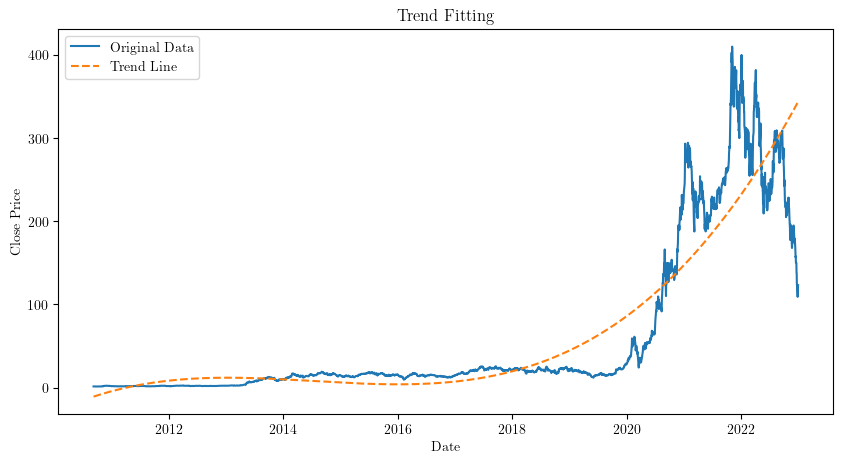

In [26]:
# Print coefficients
print("Coefficients of the linear fit:", coefficients)

# Calculate fitted values
fitted_values = poly_fit(x)

# Add a new column to the DataFrame for fitted values (trend)
df['Trend'] = fitted_values

# Print the first few rows of the DataFrame to verify
print(df.head())

# Optional: Plot the original data and the trend line
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(df.index, df['Close'], label='Original Data')
plt.plot(df.index, df['Trend'], label='Trend Line', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Trend Fitting')
plt.legend()
plt.show()


In [ ]:
# PLOT THE DECOMPOSED COMPONENTS
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Original data
axes[0][0].plot(t, co2, color='blue', marker='o', linestyle='-', markersize=5, label='Original') axes[0][0].set_ylabel(r"CO$_2$ concentration")

# Trend
axes[0][1].plot(t, co2, color='blue', marker='o', linestyle='-', markersize=5, label='Original')
axes[0][1].plot(t, poly_fit(t), color='cornflowerblue', marker='*', linestyle='', markersize=5,label='Trend')

axes[1][0].plot(t, co2, color='blue', marker='o', linestyle='-', markersize=5, label='Original')
axes[1][1].plot(t, poly_fit(t), color='cornflowerblue', marker='*', linestyle='', markersize=5, label='Trend')

'''
# Seasonal
axes[1][0].plot(t, co3, color='#ff7f0e', marker='o', linestyle='-', markersize=5, label='Seasonal') axes[1][0].set_xlabel(r"Time (years)")
axes[1][0].set_ylabel(r"CO$_2$ concentration")

# Residual
axes[1][1].plot(t, co2_deseasonalized, color='red', marker='o', linestyle='-', markersize=5,
,→ label='Residual') axes[1][1].set_xlabel(r"Time (years)")
'''

# Set labels and title for each subplot
plot_label = ['(a)', '(b)', '(c)', '(d)']
for i in range(2):
  for j in range(2):
    axes[i, j].text(0.04, 0.9, plot_label[i * 2 + j], transform=axes[i, j].transAxes)
    axes[i, j].legend(loc='lower right')

# Save plot
plt.tight_layout()
plt.savefig('plot.pdf', bbox_inches='tight')